# Preparation
## Downloading necessary packages

In [280]:
using JuDGE, JuMP, GLPK, CSV, DataFrames, Chain, Statistics, Plots, DataFramesMeta

## Reading csv files

In [78]:

data = CSV.read("degree_hours.csv", DataFrame)
periods = unique(data[!,"period"])
paths =   unique(data[!,"ssp"])

states = []

period = periods[1]
ssp = '-'

# Using Chain for more readable pipeline
result = @chain data begin
    filter(:period => ==(period), _)  # filter first period
    groupby([:quantile,:variable])
    combine(:count => mean)
end

push!(states,Dict(
    :period => period,
    :ssp => "-",
    :degree_hours => result
))

for period in periods[2:end]
    for ssp in paths
        # Using Chain for more readable pipeline
        result = @chain data begin
            filter(:period => ==(period), _) 
            filter(:ssp => ==(ssp), _) 
            select(:quantile, :variable, :count)
        end 
        push!(states,Dict(
            :period => period,
            :ssp => ssp,
            :degree_hours => result
        ))
    end
end
println("ok")
println(length(states))


ok
31


In [114]:
using DataFrames

# Create an empty DataFrame with proper column types
df = DataFrame(
    n = Int[], 
    p = Any[],  # Changed from Any[] to String[] since you're only pushing "-"
    depth = Int[],
    degree = Int[] 
)

for (i, state) in enumerate(states)
    if state[:period] == periods[1]
        println("start")
        push!(df, (n=i, p="-", degree=length(paths), depth=0)) 
    else
        depth = findfirst(x -> x == state[:period], periods) - 1  # Using findfirst instead of findall
        period_prev = periods[depth]

        # Fixed the comparison operator (== instead of =) and added proper conditions
        index = findfirst(x -> x[:period] == period_prev && (state[:ssp] == x[:ssp] || depth == 1), states)
        
        if index === nothing
            error("No matching state found for i=$i")
        end
        
        if state[:period] != periods[end]
            push!(df, (n=i, p=index, degree=2, depth=depth))  
        else
            push!(df, (n=i, p=index, degree=1, depth=depth))
        end
    end
end

CSV.write("Climate_tree.csv",df)

start


"Climate_tree.csv"

In [153]:
df1 = states[1][:degree_hours]
res1 = filter(x -> x["variable"] == "CDH", df1)


Row,quantile,variable,count_mean
,Float64,String3,Float64
1,0.0,CDH,82292.2
2,3.45866e-5,CDH,164.4
3,0.286584,CDH,310.2
4,0.582147,CDH,302.4
5,0.883386,CDH,305.4
6,1.19264,CDH,293.8
7,1.51649,CDH,291.8
8,1.84905,CDH,280.2
9,2.20259,CDH,283.4


In [120]:
mytree, p = tree_from_file("Climate_tree.csv")
JuDGE.print_tree(mytree)

--1
  --2
    --7
      --12
        --17
          --22
            --27
  --3
    --8
      --13
        --18
          --23
            --28
  --4
    --9
      --14
        --19
          --24
            --29
  --5
    --10
      --15
        --20
          --25
            --30
  --6
    --11
      --16
        --21
          --26
            --31


In [149]:
data = Dict( zip( collect(mytree,order=:breadth), states) )

period = Dict( zip(collect(mytree,order=:breadth), [d[:period] for d in states]))
ssp = Dict( zip(collect(mytree,order=:breadth), [d[:ssp] for d in states]))
degree_hour = Dict( zip(collect(mytree,order=:breadth), [d[:degree_hours] for d in states]))


Dict{AbstractTree, DataFrame} with 31 entries:
  Subtree rooted at node 8… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 2… => 44×3 DataFrame…
  Leaf node 29              => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 3… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 9… => 44×3 DataFrame…
  Leaf node 31              => 44×3 DataFrame…
  Leaf node 27              => 44×3 DataFrame…
  Subtree rooted at node 6… => 44×3 DataFrame…
  Leaf node 28              => 44×3 DataFrame…
  Subtree rooted at node 2… => 44×3 DataFrame…
  Subtree rooted at node 2… => 44×3 DataFrame…
  Subtree rooted at node 5… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Leaf node 30              => 44×3 DataFrame…
  Subtree rooted at node 2… => 44×3 DataFrame…
  Subtree roo

In [148]:

JuDGE.print_tree(mytree,ssp)
JuDGE.print_tree(mytree,period)

--1 (-)
  --2 (ssp119)
    --7 (ssp119)
      --12 (ssp119)
        --17 (ssp119)
          --22 (ssp119)
            --27 (ssp119)
  --3 (ssp126)
    --8 (ssp126)
      --13 (ssp126)
        --18 (ssp126)
          --23 (ssp126)
            --28 (ssp126)
  --4 (ssp245)
    --9 (ssp245)
      --14 (ssp245)
        --19 (ssp245)
          --24 (ssp245)
            --29 (ssp245)
  --5 (ssp370)
    --10 (ssp370)
      --15 (ssp370)
        --20 (ssp370)
          --25 (ssp370)
            --30 (ssp370)
  --6 (ssp585)
    --11 (ssp585)
      --16 (ssp585)
        --21 (ssp585)
          --26 (ssp585)
            --31 (ssp585)
--1 (2021-2031)
  --2 (2031-2041)
    --7 (2041-2051)
      --12 (2051-2061)
        --17 (2061-2071)
          --22 (2071-2081)
            --27 (2081-2091)
  --3 (2031-2041)
    --8 (2041-2051)
      --13 (2051-2061)
        --18 (2061-2071)
          --23 (2071-2081)
            --28 (2081-2091)
  --4 (2031-2041)
    --9 (2041-2051)
      --14 (2051-2061)
        -

In [373]:
JuDGE_SP_Solver = optimizer_with_attributes(GLPK.Optimizer, "msg_lev" => 0, "mip_gap" => 0.0)
function sub_problems(node)
    sp = Model(JuDGE_SP_Solver)

    CDH = filter(x -> x["variable"] == "CDH", degree_hour[node])
    HDH = filter(x -> x["variable"] == "HDH", degree_hour[node])
    
    nCDH = nrow(CDH)
    nHDH = nrow(HDH)
    @variable(sp, 0 <= H_heat_prod[1:nHDH] <= 10)
    @variable(sp, 0 <= H_heat_unmet[1:nHDH])
    @variable(sp, 0 <= C_heat_prod[1:nCDH] <= 10)
    @variable(sp, 0 <= C_heat_unmet[1:nCDH])
    @constraint(sp, MeetingHDemand[h in 1:nHDH], H_heat_prod[h] + H_heat_unmet[h] == HDH[h,"quantile"])
    @constraint(sp, MeetingCDemand[h in 1:nCDH], C_heat_prod[h] + C_heat_unmet[h] == CDH[h,"quantile"])
    
    @expansion(sp, 0<= invest[1:num_invest] <= 10, duration = 2)
    @capitalcosts(sp, sum(invest[i]*1000 for i=1:num_invest)*1000)
    
    # @variable(sp, y[1:num_items], Bin)
    
    # @constraint(sp, BagExtension, sum(y[i]*item_volume[node][i] for i in 1:num_items) <=
    #         initial_volume + sum(invest_volume[i] * invest[i] for i in 1:num_invest))
    
    @objective(sp, Min, sum(H_heat_unmet[h] + C_heat_unmet[h] for h in 1:nCDH))
    
    return sp
end

sub_problems (generic function with 1 method)

In [374]:
JuDGE_MP_Solver = optimizer_with_attributes((method=GLPK.INTERIOR) -> GLPK.Optimizer(),
							"msg_lev" => 0, "mip_gap" => 0.0)
judy = JuDGEModel(mytree, ConditionallyUniformProbabilities, sub_problems, JuDGE_MP_Solver)


1

[ Info: Establishing JuDGE model for tree: Subtree rooted at node 1 containing 31 nodes
[ Info: Building JuMP Model for node 


2712172227381318232849141924295101520253061116212631s...Complete
Complete
Complete


[ Info: Checking sub-problem format...
[ Info: Building master problem...


JuDGE Model with:
  Tree: Subtree rooted at node 1 containing 31 nodes
  Expansion variables: invest 

In [375]:
JuDGE.solve(judy,termination=Termination(rlx_abstol=10^-7),verbose=1)


Relaxed ObjVal  |   Upper Bound   Lower Bound  |  Absolute Diff   Relative Diff  |  Fractional  |      Time     Iter
  2.400003e+08  |  2.400003e+08          -Inf  |            Inf             NaN  |           0  |     0.010        1
  1.800003e+08  |  1.800003e+08          -Inf  |            Inf             NaN  |           0  |     0.012        2
  2.922061e+02  |  2.922061e+02          -Inf  |            Inf             NaN  |           0  |     0.014        3
  2.922061e+02  |  2.922061e+02          -Inf  |            Inf             NaN  |           0  |     0.015        4
  2.922061e+02  |  2.922061e+02          -Inf  |            Inf             NaN  |           0  |     0.015        5*

Stalled: exiting.


[ Info: Solving JuDGE model for tree: Subtree rooted at node 1 containing 31 nodes


In [387]:
solution = JuDGE.solution_to_dictionary(judy)
node = JuDGE.get_node(mytree,[1,5,1,1,1,1])
short_sol = solution[node]
HDH = filter(x -> x["variable"] == "HDH", degree_hour[node])
CDH = filter(x -> x["variable"] == "CDH", degree_hour[node])

Row,quantile,variable,count
,Float64,String3,Int64
1,0.0,CDH,79247
2,3.45866e-5,CDH,172
3,0.286584,CDH,331
4,0.582147,CDH,306
5,0.883386,CDH,327
6,1.19264,CDH,332
7,1.51649,CDH,311
8,1.84905,CDH,347
9,2.20259,CDH,395


22×3 DataFrame
 Row │ Keys   H_heat_unmet  H_heat_prod 
     │ Int64  Float64       Float64     
─────┼──────────────────────────────────
   1 │     1      0.0        0.0
   2 │     2      0.0        2.64486e-5
   3 │     3      0.0        0.621909
   4 │     4      0.0        1.23367
   5 │     5      0.0        1.83515
   6 │     6      0.0        2.43077
   7 │     7      0.0        3.03138
   8 │     8      0.0        3.6348
   9 │     9      0.0        4.23829
  10 │    10      0.0        4.84742
  11 │    11      0.0        5.46485
  12 │    12      0.0        6.09205
  13 │    13      0.0        6.74573
  14 │    14      0.0        7.42416
  15 │    15      0.0        8.12186
  16 │    16      0.0        8.81697
  17 │    17      0.0        9.54146
  18 │    18      0.368608  10.0
  19 │    19      1.36605   10.0
  20 │    20      2.78734   10.0
  21 │    21      4.94914   10.0
  22 │    22     21.8297    10.0
22×3 DataFrame
 Row │ Keys   C_heat_unmet  C_heat_prod 
     │ Int64 

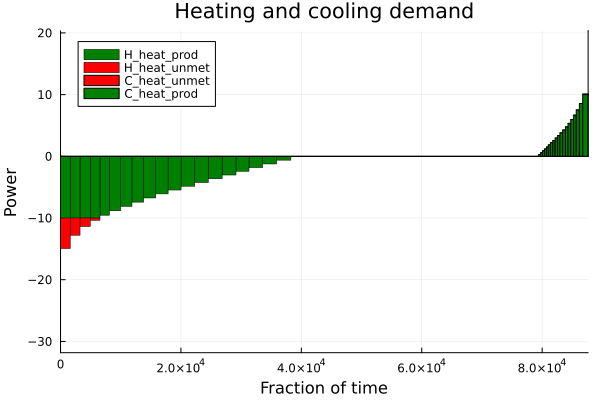

In [398]:
using DataFrames
using Plots

# Extract keys and sort them
H_keys = sort([parse(Int64, k) for k in keys(short_sol[:H_heat_prod])])

# Prepare data for plotting
H_unmet_values = [short_sol[:H_heat_unmet]["$(key)"] for key in H_keys]
H_prod_values  = [short_sol[:H_heat_prod]["$(key)"] for key in H_keys]
H_hours = Array(HDH[!,"count"])
H_cum_hours = cumsum(H_hours)

# Create DataFrame
df = DataFrame(
    Keys         = H_keys,
    H_heat_unmet = H_unmet_values,
    H_heat_prod  = H_prod_values
)


println(df)
data_matrix = Matrix(df[:, end:-1:2])

# Plotting
groupedbar(
    reverse(cumsum(reverse(H_hours))) .- H_hours/2,          # shifted x-positions
    -data_matrix,
    bar_position = :stack,
    bar_width    = (H_hours),
    label        = ["H_heat_prod" "H_heat_unmet"],
    xlabel       = "Fraction of time",
    ylabel       = "Power",
    title        = "Stacked Bar Plot",
    color       = ["green" "red"],
    xlims        = (0,cum_hours[end]),
    linewidth    = 0.5
)
data_matrix = Matrix(df[:, 2:end])



# Extract keys and sort them
C_keys = sort([parse(Int64, k) for k in keys(short_sol[:C_heat_prod])])

# Prepare data for plotting
C_unmet_values = [short_sol[:C_heat_unmet]["$(key)"] for key in C_keys]
C_prod_values  = [short_sol[:C_heat_prod]["$(key)"] for key in C_keys]
C_hours = Array(CDH[!,"count"])
C_cum_hours = cumsum(C_hours)

# Create DataFrame
df = DataFrame(
    Keys         = C_keys,
    C_heat_unmet = C_unmet_values,
    C_heat_prod  = C_prod_values
)


data_matrix = Matrix(df[:, 2:end])

println(df)
groupedbar!(
    cumsum(C_hours) .- C_hours/2,          # shifted x-positions
    data_matrix,
    bar_position = :stack,
    bar_width    = (C_hours),
    label        = ["C_heat_unmet" "C_heat_prod"],
    xlabel       = "Fraction of time",
    ylabel       = "Power",
    title        = "Heating and cooling demand",
    color       = ["red" "green"],
    xlims        = (0*cum_hours[end],cum_hours[end])
)
